# Quantum Multi‑Armed Bandit (Qiskit) — policy as a parameterized circuit
This replaces the PennyLane policy circuit with a **Qiskit parameterized circuit** that outputs **action probabilities** via measurement.

**Outputs you asked for:** the **policy circuit** (ansatz) and measured bitstrings.

In [1]:
%pip -q install "qiskit>=1.0" "qiskit-ibm-runtime>=0.20" "qiskit-algorithms>=0.3" numpy pandas matplotlib

Note: you may need to restart the kernel to use updated packages.


In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from dataclasses import dataclass

from qiskit import QuantumCircuit
from qiskit.circuit import ParameterVector
from qiskit.circuit.library import RealAmplitudes
from qiskit.primitives import StatevectorSampler as Sampler

## 1) Environment

In [3]:
N_ARMS = 3
TIME_STEPS = 300
ARM_PROBS = np.array([0.2, 0.5, 0.8])  # true (unknown) reward probs in a bandit

rng = np.random.default_rng(7)

def pull_arm(arm: int) -> int:
    return int(rng.random() < ARM_PROBS[arm])

## 2) Quantum policy circuit
We represent actions with **2 qubits** (00, 01, 10, 11). We map 11 to arm 2 so all bitstrings map to a valid arm.

You can change this mapping if you want a different encoding.

In [4]:
N_QUBITS = 2
ansatz = RealAmplitudes(num_qubits=N_QUBITS, reps=2, entanglement="full")
theta = ansatz.parameters  # parameter objects

print("Policy circuit (ansatz):")
print(ansatz.decompose().draw(output="text"))

Policy circuit (ansatz):
     ┌──────────┐     ┌──────────┐     ┌──────────┐
q_0: ┤ Ry(θ[0]) ├──■──┤ Ry(θ[2]) ├──■──┤ Ry(θ[4]) ├
     ├──────────┤┌─┴─┐├──────────┤┌─┴─┐├──────────┤
q_1: ┤ Ry(θ[1]) ├┤ X ├┤ Ry(θ[3]) ├┤ X ├┤ Ry(θ[5]) ├
     └──────────┘└───┘└──────────┘└───┘└──────────┘


C:\Users\KIIT0001\AppData\Local\Temp\ipykernel_11280\2214952709.py:2: DeprecationWarning: The class ``qiskit.circuit.library.n_local.real_amplitudes.RealAmplitudes`` is deprecated as of Qiskit 2.1. It will be removed in Qiskit 3.0. Use the function qiskit.circuit.library.real_amplitudes instead.
  ansatz = RealAmplitudes(num_qubits=N_QUBITS, reps=2, entanglement="full")


In [5]:
import numpy as np
from qiskit import QuantumCircuit

def bitstring_to_arm(bitstring: str) -> int:
    """Map an n_qubit bitstring to an arm index (0..N_ARMS-1)."""
    idx = int(bitstring, 2)
    return min(idx, N_ARMS - 1)

def _databin_get_counts(databin):
    """Extract counts from a Qiskit Primitives V2 DataBin (StatevectorSampler / SamplerV2)."""
    # Typical classical register names
    for name in ("c", "meas", "cr"):
        if hasattr(databin, name):
            obj = getattr(databin, name)
            if hasattr(obj, "get_counts"):
                return obj.get_counts()

    # Fallback: find any attribute that provides get_counts()
    for name in dir(databin):
        if name.startswith("_"):
            continue
        obj = getattr(databin, name, None)
        if hasattr(obj, "get_counts"):
            return obj.get_counts()

    raise AttributeError(
        "Could not find measurement counts in sampler result. "
        "Ensure the circuit includes measurements into a classical register."
    )

def sample_action_probs(sampler, params: np.ndarray, shots: int = 1024):
    """Run the policy circuit and return (probs_over_arms, raw_counts, measured_circuit)."""
    # Bind parameters to the ansatz
    bind = {p: float(v) for p, v in zip(theta, params)}
    bound_ansatz = ansatz.assign_parameters(bind, inplace=False)

    # Build a measured circuit (for V2 Sampler)
    qc_m = QuantumCircuit(N_QUBITS, N_QUBITS)  # classical register name is usually "c"
    qc_m.compose(bound_ansatz, inplace=True)
    qc_m.measure(range(N_QUBITS), range(N_QUBITS))

    # Run on sampler (V2 primitives)
    job = sampler.run([qc_m], shots=shots)
    result0 = job.result()[0]
    counts = _databin_get_counts(result0.data)

    # Convert counts -> probabilities over arms
    probs = np.zeros(N_ARMS, dtype=float)
    total = sum(counts.values()) if counts else 1
    for b, c in counts.items():
        b_clean = b.replace(" ", "")
        arm = bitstring_to_arm(b_clean)
        probs[arm] += c / total

    return probs, counts, qc_m

## 3) Simple policy-gradient style update (SPSA)
We use **SPSA** (gradient-free) to tune circuit parameters to maximize observed reward.

This is intentionally lightweight and hardware-friendly (only needs circuit samples).

In [6]:
from qiskit_algorithms.optimizers import SPSA

sampler = Sampler()

# Initial parameters for the policy circuit (ansatz parameters)
params0 = rng.normal(0, 0.5, size=len(theta))

# Objective: negative expected reward (we minimize)
def objective(params, shots=1024, batch=20):
    total_reward = 0.0
    for _ in range(batch):
        probs, _, _ = sample_action_probs(sampler, params, shots=shots)
        arm = int(np.argmax(probs))
        total_reward += pull_arm(arm)
    return -total_reward / batch

# Train with SPSA (hardware-friendly)
opt = SPSA(maxiter=80, learning_rate=0.2, perturbation=0.1)
opt_result = opt.minimize(fun=objective, x0=params0)

params_star = opt_result.x
print("Optimization done. Final objective:", opt_result.fun)

# Show final action probabilities & circuit
probs_star, counts_star, final_circuit = sample_action_probs(sampler, params_star, shots=4096)
print("Final action probabilities (approx):", probs_star)
print("Sample counts:", counts_star)
print(final_circuit.draw(output="text"))

Optimization done. Final objective: -0.55
Final action probabilities (approx): [0.0090332  0.02685547 0.96411133]
Sample counts: {'11': 1602, '10': 2347, '01': 110, '00': 37}
     ┌──────────────────────────────────────────────────────────────────┐┌─┐   
q_0: ┤0                                                                 ├┤M├───
     │  RealAmplitudes(-2.1494,0.19937,0.11293,-0.2953,0.72266,-3.1458) │└╥┘┌─┐
q_1: ┤1                                                                 ├─╫─┤M├
     └──────────────────────────────────────────────────────────────────┘ ║ └╥┘
c: 2/═════════════════════════════════════════════════════════════════════╩══╩═
                                                                          0  1 


## 4) Rollout comparison vs classical ε-greedy Q-values

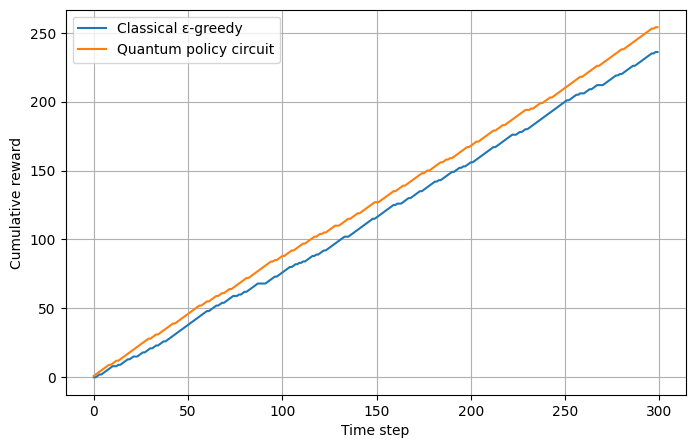

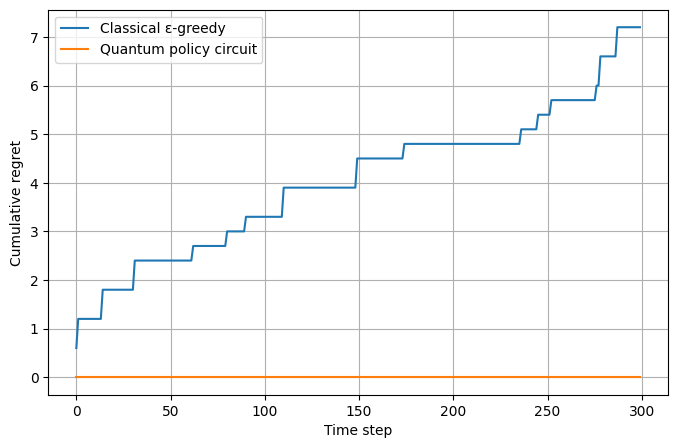

,Model,Final Cumulative Reward,Final Cumulative Regret
0,Classical ε-greedy,236,7.2
1,Quantum policy circuit,254,0.0


In [7]:
def run_classical_bandit(alpha=0.1, eps=0.1):
    best_arm_prob = float(np.max(ARM_PROBS))
    Q = np.zeros(N_ARMS)
    metrics = {"t": [], "cum_reward": [], "cum_regret": [], "action": []}
    cum_reward = 0
    cum_regret = 0.0

    for t in range(TIME_STEPS):
        if rng.random() < eps:
            a = int(rng.integers(N_ARMS))
        else:
            a = int(np.argmax(Q))

        r = pull_arm(a)
        Q[a] += alpha * (r - Q[a])
        cum_reward += r
        cum_regret += best_arm_prob - float(ARM_PROBS[a])

        metrics["t"].append(t)
        metrics["cum_reward"].append(cum_reward)
        metrics["cum_regret"].append(cum_regret)
        metrics["action"].append(a)

    return metrics


def run_quantum_bandit(params_fixed):
    best_arm_prob = float(np.max(ARM_PROBS))
    metrics = {"t": [], "cum_reward": [], "cum_regret": [], "action": []}
    cum_reward = 0
    cum_regret = 0.0

    for t in range(TIME_STEPS):
        probs, _, _ = sample_action_probs(sampler, params_fixed, shots=512)
        a = int(np.argmax(probs))

        r = pull_arm(a)
        cum_reward += r
        cum_regret += best_arm_prob - float(ARM_PROBS[a])

        metrics["t"].append(t)
        metrics["cum_reward"].append(cum_reward)
        metrics["cum_regret"].append(cum_regret)
        metrics["action"].append(a)

    return metrics

m_class = run_classical_bandit()
m_quant = run_quantum_bandit(params_star)

plt.figure(figsize=(8,5))
plt.plot(m_class["t"], m_class["cum_reward"], label="Classical ε-greedy")
plt.plot(m_quant["t"], m_quant["cum_reward"], label="Quantum policy circuit")
plt.xlabel("Time step"); plt.ylabel("Cumulative reward"); plt.legend(); plt.grid(True); plt.show()

plt.figure(figsize=(8,5))
plt.plot(m_class["t"], m_class["cum_regret"], label="Classical ε-greedy")
plt.plot(m_quant["t"], m_quant["cum_regret"], label="Quantum policy circuit")
plt.xlabel("Time step"); plt.ylabel("Cumulative regret"); plt.legend(); plt.grid(True); plt.show()

pd.DataFrame({
    "Model": ["Classical ε-greedy", "Quantum policy circuit"],
    "Final Cumulative Reward": [m_class["cum_reward"][-1], m_quant["cum_reward"][-1]],
    "Final Cumulative Regret": [m_class["cum_regret"][-1], m_quant["cum_regret"][-1]],
})

## 5) Run on IBM Quantum Platform (optional)
Swap `Sampler()` with `SamplerV2` in a session.

In [8]:
# from qiskit_ibm_runtime import QiskitRuntimeService, SamplerV2, Session
# service = QiskitRuntimeService(channel="ibm_quantum")
# backend = service.least_busy(operational=True, simulator=False)
# with Session(service=service, backend=backend) as session:
#     sampler = SamplerV2(session=session)
#     # Now re-run training or just evaluation with sampler
print("Optional IBM Runtime cell ready.")

Optional IBM Runtime cell ready.
